# Imports and API

In [1]:
import sys
import os
from copy import deepcopy
from typing import Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import wandb

sys.path.append("../../")

# Style for making nice-looking paper plots with page-scale figure size units
sns.set_theme(
    style="ticks",
    context="paper",
    palette="deep",
    rc={
        "font.size": 5,
        "axes.titlesize": 6,
        "axes.labelsize": 6,
        "axes.labelpad": 2,
        "xtick.labelsize": 4.5,
        "ytick.labelsize": 4.5,
        "legend.title_fontsize": 4.5,
        "legend.fontsize": 4.5,
        "legend.markerscale": 0.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.4,
        "xtick.major.width": 0.4,
        "ytick.major.width": 0.4,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,
        "xtick.minor.width": 0.2,
        "ytick.minor.width": 0.2,
        "figure.constrained_layout.use": True,
        "figure.dpi": 200,
    },
)


# Weights & Biases
api = wandb.Api()


def get_run_results(
    entity: str,
    project: str,
    metrics: list[str],
    filters: dict[str, Any],
    posthoc_nested_config_filters: dict[str, Any] = {},
    x_axis: str = "epoch",
    user: str | None = None,
    save_path: str | None = None,
) -> pd.DataFrame:
    """Pulls data from the W&B API and returns a dataframe with either the best epoch performance for each run
    (when `best_epoch=True`) or the entire training trajectory across runs (when `best_epoch=False`).

    Args:
        entity (str): W&B entity.
        dataset (str): The W&B project.
        metrics (list[str]): Logged metrics we want to keep.
        filters (dict[str, Any]): W&B API filters used to select only a subset of runs. See code below for examples.
        x_axis (str): The x-axis to plot the metrics against.
        save_path (str, optional): Optionally save the resulting dataframe. Note that if the file already exists, we retrieve its data and return that rather than querying the API. Defaults to `None`.

    Returns:
        pd.DataFrame: Dataframe of results. It contains the run id, epoch, config arguments, and `metrics`.
    """
    # If data has already been downloaded, don't make another API call
    if os.path.exists(save_path):
        print(f"Loading from cached file {save_path}...")
        data = pd.read_csv(save_path)
        return data

    # Fetch all run data from the API
    runs = api.runs(f"{entity}/{project}", filters=filters)
    if user is not None:
        runs = [run for run in runs if run.user.username == user]
    filtered_runs = []
    for run in runs:
        config = run.config
        is_valid = True
        for key, value in posthoc_nested_config_filters.items():
            nested_attribute = key.split(".")
            attribute_config = deepcopy(config)
            for attribute in nested_attribute:
                if attribute not in attribute_config:
                    is_valid = False
                    break
                attribute_config = attribute_config[attribute]
            if isinstance(attribute_config, list):
                attribute_config = ",".join(attribute_config)
            if attribute_config != value:
                is_valid = False
                break
        if is_valid:
            filtered_runs.append(run)
    runs = filtered_runs

    # Collect all of the run histories into a dataframe
    data = []
    for run in runs:
        if "self" in run.config:
            del run.config["self"]  # Present in SGD runs, but causes python errors
        # List values cause problems when assigning to a dataframe
        for key, value in run.config.items():
            if isinstance(value, list):
                run.config[key] = ", ".join(value)
        run_data = run.history(samples=1000000, x_axis=x_axis, keys=metrics)
        run_data = run_data.assign(run_id=run.id, **run.config)
        data.append(run_data)
    data = pd.concat(data)

    # Re-order columns
    data = data[["run_id", x_axis] + metrics + list(run.config.keys())]

    # Cache data
    if save_path is not None:
        data.to_csv(save_path, index=False)

    return data


# Plotting
"""default method order in plots

    Example:
    ["prequential", "train", ...]
"""
default_method_order = [
]

"""default method color in plots

    Example:
    "prequential": sns.color_palette()[0],
    "train": sns.color_palette()[1],
    ...
"""
default_method_hue = {
}


"""rename metrics

    Example: 
    "val_tasks/n_sample_loss_train": "Training error",
    "b_kl": "Generalization error",
"""
metric_name_map = {
}


def custom_plot(
    ax,
    data,
    x,
    y,
    hue="method",
    hide_legend: bool = True,
    errorbar: str = "se",
    **kwargs,
):
                        # methods = data["method"].unique()
    hue_order = None    # [m for m in default_method_order if m in methods]
    palette = None      # {m: default_method_hue[m] for m in methods}

    sns.lineplot(
        data=data,
        x=x,
        y=y,
        hue=hue,
        hue_order=hue_order,
        palette=palette,
        errorbar=errorbar,
        ax=ax,
        **kwargs,
    )

    ax.set(
        xscale="log",
        xlabel="add your x label here",
        ylabel="add your y label here", #metric_name_map[y],
    )
    if hide_legend:
        ax.legend().remove()

    return ax


def smooth_data(
    data,
    metrics,
    sigma=20.0,
):
    metrics = [m for m in metrics if m in data.columns]

    def smooth(x, smoothing_columns, sigma):
        x.loc[:, smoothing_columns] = gaussian_filter1d(
            x[smoothing_columns], sigma, axis=0
        )
        return x

    data = data.sort_values(["run_id","n_samples"])
    data = (
        data.groupby("run_id")
        .apply(
            lambda x: smooth(x, metrics, sigma=sigma),
            include_groups=False,
        )
        .reset_index(level="run_id")
    )

    return data

## Example of how to use the API to get the data:

In [2]:
# Example from the project "Prequential-ICL"
data_icl_linreg = get_run_results(
    entity="dhanya-shridar",
    project="Prequential-ICL",
    metrics=["val_tasks/n_sample_loss_nexttoken"],
    x_axis="n_samples",
    filters={
        "config.dataset.name": "linear_regression",
        "config.task_name": "meta_optimizer",
        "tags": {
            "$in": [
                "experiments/prequential_vs_train/regression",
            ]
        },
    },
    user="ericelmoznino",
    save_path="data/icl_linreg.csv",
)
data_icl_linreg = smooth_data(data_icl_linreg, ["val_tasks/n_sample_loss_nexttoken"])
data_icl_linreg["method"] = data_icl_linreg["meta_objective"]

Loading from cached file data/icl_linreg.csv...


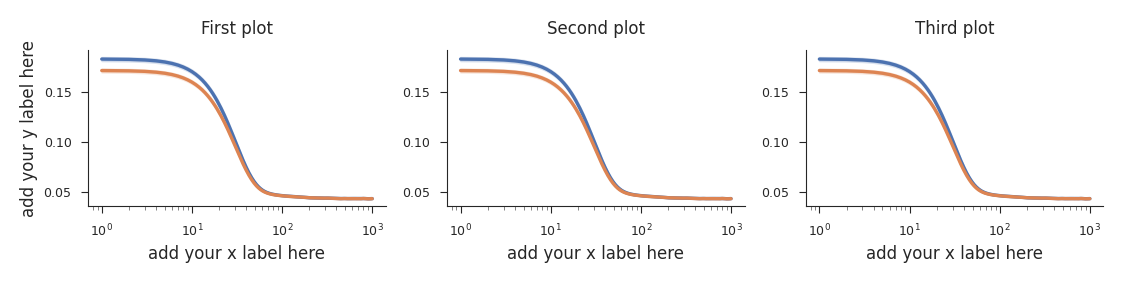

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(5.5, 1.3))

custom_plot(axs[0], data_icl_linreg, x="n_samples", y="val_tasks/n_sample_loss_nexttoken")
custom_plot(axs[1], data_icl_linreg, x="n_samples", y="val_tasks/n_sample_loss_nexttoken")
custom_plot(axs[2], data_icl_linreg, x="n_samples", y="val_tasks/n_sample_loss_nexttoken")

axs[0].set(title="First plot")
axs[1].set(title="Second plot", ylabel=None)
axs[2].set(title="Third plot", ylabel=None)

fig.savefig("saved/example.pdf")

plt.show()

# Appendix

This section contains all the plots that will go in Appendix